In [1]:
import os
import multiprocessing
multiprocessing.cpu_count()

16

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
from gluoncv.utils.metrics.segmentation import SegmentationMetric
from mxnet.gluon.data.vision import transforms
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from importlib import reload
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.contrib import amp
import numpy as np
import os
from sklearn import metrics
import time
from tqdm.notebook import tqdm

# Local Libraries
import pedestrian
import seg_model

## Dataset Import

In [3]:
# Penn-Fudan Pedestrian Dataset
# https://www.cis.upenn.edu/~jshi/ped_html/
reload(pedestrian)

if not os.path.exists(pedestrian.PEDESTRIAN_FILE):
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

pedestrian_path = os.getcwd()

# Datasets
pedestrian_train_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="train",
    is_segmentation_task=True,
    invert_masks=False)

pedestrian_val_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="val",
    is_segmentation_task=True,
    invert_masks=False)

pedestrian_test_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="test",
    is_segmentation_task=True,
    invert_masks=False)

Read 120 images with 307 pedestrians
Read 25 images with 68 pedestrians
Read 25 images with 48 pedestrians


In [4]:
# Further pre-processing
# Training pre-processing optimized for speed
# Evaluation pre-processing optimized for visualizations
image_size = 480

imagenet_transform = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

size_transform = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size)
])

train_val_transform = lambda data, output: (imagenet_transform(data), size_transform(output))
test_transform = lambda data, output: (size_transform(data), mx.nd.moveaxis(size_transform(output), -1, 0))

p_train = pedestrian_train_dataset.transform(train_val_transform)
p_val   = pedestrian_val_dataset.transform(train_val_transform)
p_test  = pedestrian_test_dataset.transform(test_transform)

## Naive Training

In [5]:
# Single GPU training
ctx = mx.gpu()

In [6]:
# Model
deeplab_ft_direct_naive = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)

# FT-Direct, no freezing layers
# # Freeze Layers (keeping track of the updated parameters)
# updated_params = []
# for param in deeplab_ft_direct_f32.collect_params().values():
#     if param.grad_req == "write":
#         param.grad_req = "null"
#         updated_params += [param.name]

# Replace the last layers
deeplab_ft_direct_naive.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_ft_direct_naive.head.initialize(ctx=ctx)

# DeepLab v3 has an additional auxiliary output for training/loss
# Not required for our person detector
deeplab_ft_direct_naive.aux = False
for param in deeplab_ft_direct_naive.auxlayer.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"

deeplab_ft_direct_naive.hybridize(static_alloc=True, static_shape=True)

model_filename_ft_direct_naive = "deeplab_resnet101_coco_ft_direct_naive.params"

reload(seg_model)

loss_fn = gcv.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
epochs = 10
batch_size = 4

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(deeplab_ft_direct_naive.collect_params(), "sgd", {"learning_rate": 0.1})

start_time = time.time()

training_loss, validation_loss = seg_model.training_loop(
    deeplab_ft_direct_naive,
    loss_fn, 
    trainer, 
    epochs, 
    batch_size, 
    p_train, 
    p_val, 
    model_filename_ft_direct_naive, 
    ctx)

print("Training time for 10 epochs:", time.time() - start_time, "/ Best validation loss:", min(validation_loss))

[13:47:34] /work/mxnet/src/base.cc:79: cuDNN lib mismatch: linked-against version 8200 != compiled-against version 8201.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.
/home/ext_andres_pereztorres_oxbotica_/.local/lib/python3.9/site-packages/mxnet/gluon/block.py:825: UserWarning: Parameter deeplabv30__fcnhead0_hybridsequential0_batchnorm0_beta, deeplabv30__fcnhead0_hybridsequential0_conv0_weight, deeplabv30__fcnhead0_hybridsequential0_batchnorm0_gamma, deeplabv30__fcnhead0_hybridsequential0_batchnorm0_running_mean, deeplabv30__fcnhead0_hybridsequential0_conv1_bias, deeplabv30__fcnhead0_hybridsequential0_conv1_weight, deeplabv30__fcnhead0_hybridsequential0_batchnorm0_running_var is not used by any computation. Is this intended?
  out = self.forward(*args)
[13:47:39] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0

E:    1, TrL: 0.263924, VL: 0.219095 --- Updating saved model
E:    2, TrL: 0.126168, VL: 0.156855 --- Updating saved model
E:    3, TrL: 0.097776, VL: 0.123904 --- Updating saved model
E:    4, TrL: 0.077008, VL: 0.143309
E:    5, TrL: 0.066938, VL: 0.106674 --- Updating saved model
E:    6, TrL: 0.062046, VL: 0.097026 --- Updating saved model
E:    7, TrL: 0.055357, VL: 0.098910
E:    8, TrL: 0.050288, VL: 0.105119
E:    9, TrL: 0.047652, VL: 0.105912
E:   10, TrL: 0.045661, VL: 0.094164 --- Updating saved model
Training time for 10 epochs: 638.9948952198029 / Best validation loss: 0.09416388


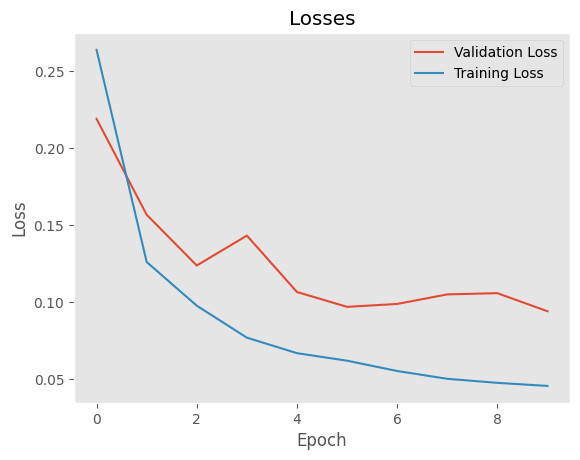

In [7]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

### Evaluation

#### Quantitative Evaluation: mean IoU & Pixel Accuracy

In [8]:
# Quantitative Evaluation
deeplab_ft_direct_naive.load_parameters(model_filename_ft_direct_naive)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ft_direct_naive(transformed_image)
    segmentation_metrics.update(gt_mask, output[0])
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

[14:00:50] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


PixAcc:  0.9627800347222222
mIoU  :  0.9070747450272697


#### Qualitative Evaluation: Image Segmentation Example

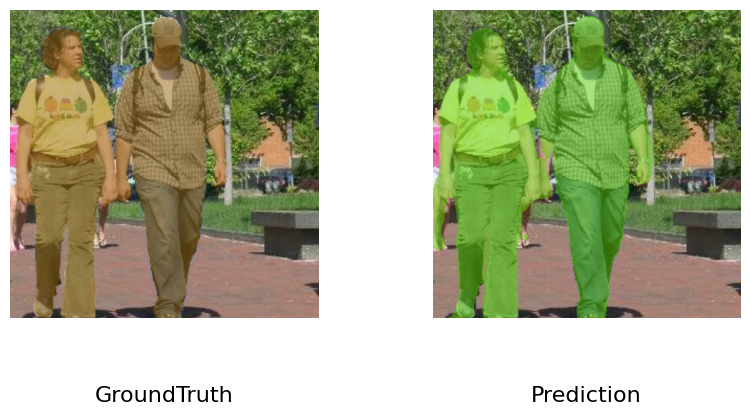

In [10]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_ft_direct_naive(transformed_image)
filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Optimal Data Loading: CPU/GPU Optimization

In [5]:
# Context variable is now a list,
# with each element corresponding to a GPU device
ctx_list = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]
num_gpus = len(ctx_list)

In [6]:
# Further pre-processing
# Training pre-processing optimized for speed
# Evaluation pre-processing optimized for visualizations
image_size = 480

input_transform_fn = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(image_size, keep_ratio=True),
    mx.gluon.data.vision.transforms.CenterCrop(image_size),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])

input_transform_lambda_fn = lambda x_list: [input_transform_fn(x) for x in x_list]

to_gpu_fn = lambda x: mx.gluon.utils.split_and_load(x, ctx_list=ctx_list)

input_transform_fn_gpu = mx.gluon.data.vision.transforms.Compose([
    to_gpu_fn,
    # input_transform_fn
    input_transform_lambda_fn
])

output_transform_fn = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size)
])

output_transform_lambda_fn = lambda x_list: [output_transform_fn(x) for x in x_list]

output_transform_fn_gpu = mx.gluon.data.vision.transforms.Compose([
    to_gpu_fn,
    # output_transform_fn
    output_transform_lambda_fn
])

train_val_transform = lambda data, output: (input_transform_fn_gpu(data), output_transform_fn_gpu(output))
test_transform = lambda data, output: (input_transform_fn_gpu(data), mx.nd.moveaxis(output_transform_fn_gpu(output), -1, 0))

p_train_opt = pedestrian_train_dataset.transform(train_val_transform)
p_val_opt   = pedestrian_val_dataset.transform(train_val_transform)
p_test_opt  = pedestrian_test_dataset.transform(test_transform)

In [7]:
len(p_val), len(p_val[0]), p_val[0][0].shape, p_val[0][1].shape

(25, 2, (3, 480, 480), (480, 480, 1))

In [8]:
val_iterator = mx.gluon.data.DataLoader(p_val, batch_size=8, shuffle=False, last_batch='rollover')

In [9]:
for val_batch in val_iterator:
    print(len(val_batch), len(val_batch[0]), len(val_batch[1]), val_batch[0][7].shape, val_batch[1][7].shape)
    break

2 8 8 (3, 480, 480) (480, 480, 1)


In [11]:
example_val = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="val",
    is_segmentation_task=True,
    invert_masks=False)

Read 25 images with 68 pedestrians


In [12]:
example_val.indexes = [120, 127]
example_val.number_images = 8
example_val.features = example_val.features[:8]
example_val.labels = example_val.labels[:8]
example_val.masks = example_val.masks[:8]

In [ ]:
def get_length_index_fn():
    global idx
    idx = 0
    def transform(src, tgt):
        global idx
        result = (src, tgt, len(src), len(tgt), idx)
        idx += 1
        return result
    return transform

In [ ]:
example_val_idx = example_val.transform(get_length_index_fn)

In [47]:
for idx, (data, label) in tqdm(enumerate(example_val)):
    gpu_idx = idx % 4
    data_gpu = data.as_in_context(mx.gpu(gpu_idx))
    break

0it [00:00, ?it/s]

## Optimal Training: Automatic Mixed Precision (AMP) + Multi-GPU

In [ ]:
# AMP
amp.init()

# Model
deeplab_ft_direct_opt = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx_list)

# FT-Direct, no freezing layers
# # Freeze Layers (keeping track of the updated parameters)
# updated_params = []
# for param in deeplab_ft_direct_f32.collect_params().values():
#     if param.grad_req == "write":
#         param.grad_req = "null"
#         updated_params += [param.name]

# Replace the last layers
deeplab_ft_direct_opt.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_ft_direct_opt.head.initialize(ctx=ctx_list)

# DeepLab v3 has an additional auxiliary output for training/loss
# Not required for our person detector
deeplab_ft_direct_opt.aux = False
for param in deeplab_ft_direct_opt.auxlayer.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"

deeplab_ft_direct_opt.hybridize(static_alloc=True, static_shape=True)

model_filename_ft_direct_opt = "deeplab_resnet101_coco_ft_direct_opt.params"

reload(seg_model)

loss_fn = gcv.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
epochs = 10
batch_size_per_gpu = 4
batch_size = len(ctx_list) * batch_size_per_gpu

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(deeplab_ft_direct_opt.collect_params(), "sgd", {"learning_rate": 0.5})

start_time = time.time()

training_loss, validation_loss = seg_model.training_loop(
    deeplab_ft_direct_opt,
    loss_fn, 
    trainer, 
    epochs, 
    batch_size, 
    p_train_opt, 
    p_val_opt, 
    model_filename_ft_direct_opt, 
    ctx_list)

print("Training time for 10 epochs:", time.time() - start_time, "/ Best validation loss:", min(validation_loss))

### Evaluation

#### Quantitative Evaluation: mean IoU & Pixel Accuracy

In [ ]:
# Quantitative Evaluation
deeplab_ft_direct_opt.load_parameters(model_filename_ft_direct_opt)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ft_direct_opt(transformed_image)
    segmentation_metrics.update(gt_mask, output[0])
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

#### Qualitative Evaluation: Image Segmentation Example

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_ft_direct_opt(transformed_image)
filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);